In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import scipy.signal
pd.options.mode.chained_assignment = None
plt.style.use('ggplot')

## 1. Connect

In [2]:
# Connect to Oracle
ora_eng = nivapy.da.connect(src='nivabase')

Connection successful.


## 2. Get project

Project of interest is called "LandSjø - Storelva/Sandnesfjorden".

In [3]:
# List all projects in the NIVADATABASE
prj_grid = nivapy.da.select_ndb_projects(ora_eng)
prj_grid

1167 projects in the NIVADATABASE.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# Get selected rows from the projects query grid
prj_df = prj_grid.get_selected_df()
prj_df

,project_id,project_name,project_description
819,7066,LandSjø-Storelva/Sandnesfjorden,None


## 3. Get stations for project

In [5]:
# Get stations for specified projects
stn_df = nivapy.da.select_ndb_project_stations(prj_df, ora_eng, drop_dups=True)
stn_df

,station_id,station_code,station_name,station_type,longitude,latitude
0,8016,ST-1,Storelva utløp,Elv,8.981030,58.670380
1,65380,LOGGER-1,Lundevannet,Innsjø,8.975329,58.667876
2,65381,LOGGER-2,Nævestadfjorden,Innsjø,9.033010,58.678680
3,65382,LOGGER-3,Kviteberg,Luft,9.033010,58.679190
4,65574,AAGTVED1,"Storelva, utløp Lundevatn",Elv,8.979543,58.668819
5,65575,AAGTVED2,"Steaelva, nederst",Elv,9.012951,58.686526
6,65576,AAGTVED3,Nævestadfjorden,Marin,9.035792,58.678973
7,69036,AAGTVED4,"Songevann, utløp",Innsjø,9.005100,58.673967
8,69037,AAGTVED5,"Sandnesfjorden, indre",Marin,9.124117,58.694217
9,69038,AAGTVED6,"Sandnesfjorden, ytre",Innsjø,9.212867,58.702417


## 4. Map of stations

With "popups" for station code.

In [6]:
nivapy.spatial.quickmap(stn_df, popup='station_code')

## 5. Get parameters

Focus on CDOM for now. Conside a long time range (2010 to present) to get all available data.

In [7]:
# Specify time period of interest
st_dt = '2010-01-01'
end_dt = '2018-12-31'

# Get available parameters
par_grid = nivapy.da.select_ndb_station_parameters(stn_df, st_dt, end_dt, ora_eng)
par_grid

37 parameters available for the selected stations and dates.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
# Get selected rows from the params query grid
par_df = par_grid.get_selected_df()
par_df

,parameter_id,parameter_name,unit
3,1782,CDOM,µg/L


## 6. Get data

In [9]:
# Get data
wc_df, dup_df = nivapy.da.select_ndb_water_chemistry(stn_df,
                                                     par_df,
                                                     st_dt,
                                                     end_dt,
                                                     ora_eng,
                                                     lod_flags=False,
                                                     drop_dups=True)
wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,CDOM_µg/L
,,,,,,,
0,65380,LOGGER-1,Lundevannet,2015-02-26 14:42:00,1.0,1.0,83.44
1,65380,LOGGER-1,Lundevannet,2015-02-26 15:42:00,1.0,1.0,83.75
2,65380,LOGGER-1,Lundevannet,2015-02-26 16:42:00,1.0,1.0,83.70
3,65380,LOGGER-1,Lundevannet,2015-02-26 17:42:00,1.0,1.0,83.79
4,65380,LOGGER-1,Lundevannet,2015-02-26 18:42:00,1.0,1.0,83.99


See what depths data are available for.

In [10]:
print('Available values for "depth1":', list(wc_df['depth1'].unique()))
print('Available values for "depth2":', list(wc_df['depth2'].unique()))

Available values for "depth1": [1.0, 4.0, 2.5, 7.0, 8.5, 5.5]
Available values for "depth2": [1.0, 4.0, 2.5, 7.0, 8.5, 5.5]


## 7. Plot data

Choose a depth and plot the raw data.

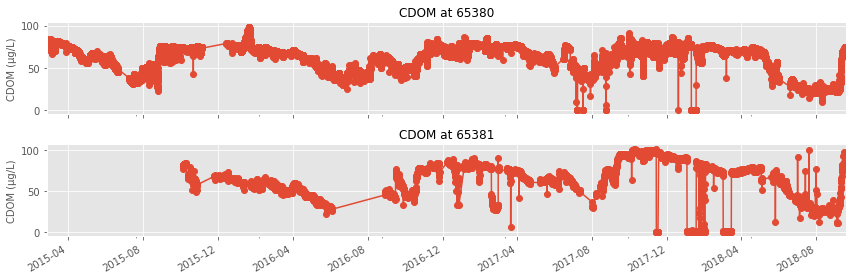

In [11]:
# Plot chem data
nivapy.plotting.plot_water_chemistry(wc_df, depth1=1, depth2=1)

## 8. Simple outlier detection

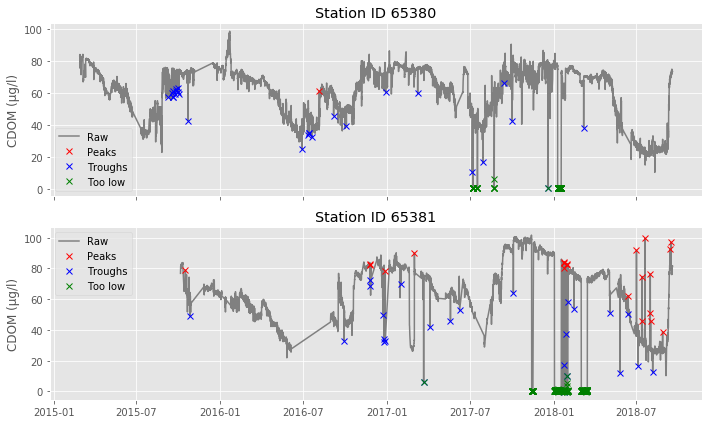

In [12]:
# Set user thresholds
spike_thresh = 10   # Spike/trough height
base_thresh = 10    # Baseline minimum

# Set depth of interest
depth1 = 1
depth2 = 1

# Get list of stations with CDOM data
stn_list = list(wc_df['station_id'].unique())

# Setup plot grid
fig, axes = plt.subplots(nrows=len(stn_list), 
                         ncols=1, 
                         figsize=(10, len(stn_list)*3),
                         sharex=True)

# Loop over stations
for idx, stn_id in enumerate(stn_list):
    # Get data at desired depth
    wc_df2 = wc_df.query('depth1 == @depth1 and '
                         'depth2 == @depth2 and '
                         'station_id == @stn_id')
    
    # Set date index and get just CDOM column
    wc_df2.set_index('sample_date', inplace=True)
    wc_df2 = wc_df2[['CDOM_µg/L']]

    # Find peaks, troughs and values that are below 'base_thresh'
    peaks, _ = scipy.signal.find_peaks(wc_df2['CDOM_µg/L'], 
                                       threshold=spike_thresh)
    troughs, _ = scipy.signal.find_peaks(-wc_df2['CDOM_µg/L'], 
                                         threshold=spike_thresh)
    too_low = wc_df2['CDOM_µg/L'] < base_thresh

    # Plot
    # Raw data
    axes[idx].plot(wc_df2.index, wc_df2['CDOM_µg/L'], ls='-', c='grey', label='Raw')
    
    # Peaks, troughs and too low
    axes[idx].plot(wc_df2.index[peaks], wc_df2['CDOM_µg/L'][peaks], 'rx', label='Peaks')
    axes[idx].plot(wc_df2.index[troughs], wc_df2['CDOM_µg/L'][troughs], 'bx', label='Troughs')
    axes[idx].plot(wc_df2.index[too_low], wc_df2['CDOM_µg/L'][too_low], 'gx', label='Too low')
    
    # Labels
    axes[idx].legend(loc='best')    
    axes[idx].set_title('Station ID %s' % stn_id)
    axes[idx].set_ylabel('CDOM (µg/l)')

plt.tight_layout()